#Predicting Loan Repayment Behavior Using LendingClub Data

#### Data Pre-Processing & Preliminary Examination:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#load dataset
loan_data = '/content/drive/MyDrive/DataBootcamp/loan_data.csv'
df = pd.read_csv(loan_data)
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


###Step 1: Data Analysis and Cleaning

In [4]:
#check for missing values
missing_values = df.isnull().sum()
print(missing_values)

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64


In [5]:
#check for duplicate rows
df.duplicated().sum()

0

In [6]:
#check data types
print(df.dtypes)

credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
dtype: object


###Step 2: Exploratory Data Analysis (EDA)


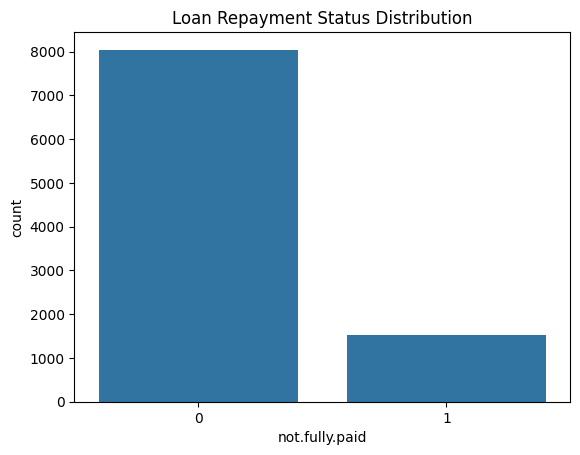

In [7]:
#check distribution of target variable (loan repayment status)
sns.countplot(x='not.fully.paid', data=df)
plt.title('Loan Repayment Status Distribution')
plt.show()

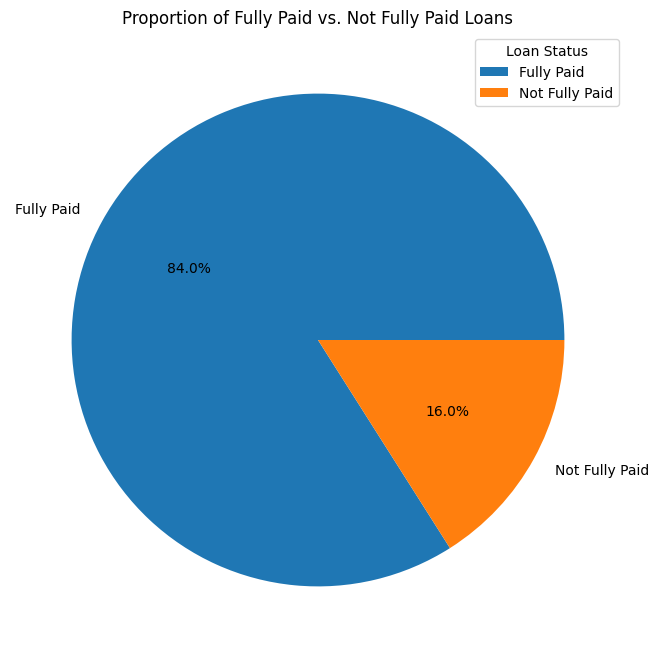

In [8]:
#pie chart for better understanding of fully paid vs. not fully paid
loan_status = df['not.fully.paid'].value_counts()
loan_status.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), labels=['Fully Paid', 'Not Fully Paid'])
plt.title('Proportion of Fully Paid vs. Not Fully Paid Loans')
plt.ylabel('')
plt.legend(title='Loan Status', labels=['Fully Paid', 'Not Fully Paid'], loc='upper right')
plt.show()

In [9]:
#check for unique values in categorical column
df['purpose'].value_counts()

,count
purpose,
debt_consolidation,3957
all_other,2331
credit_card,1262
home_improvement,629
small_business,619
major_purchase,437
educational,343


In [10]:
#group by 'purpose' & show average of repayment behavior
purpose_notpaid = df.groupby('purpose')['not.fully.paid'].mean().T

<ipython-input-11-b36e8a2f920d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=purpose_notpaid.index, y=purpose_notpaid.values, palette='coolwarm')


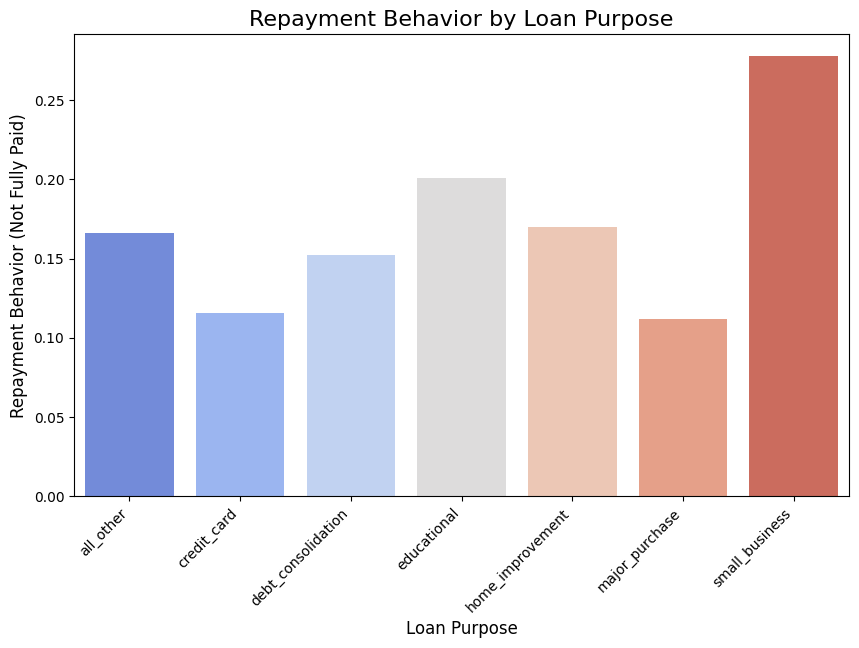

In [11]:
#bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=purpose_notpaid.index, y=purpose_notpaid.values, palette='coolwarm')
plt.title('Repayment Behavior by Loan Purpose', fontsize=16)
plt.xlabel('Loan Purpose', fontsize=12)
plt.ylabel('Repayment Behavior (Not Fully Paid)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

<ipython-input-12-338ce324187d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=inq_rep_behavior.index, y=inq_rep_behavior.values, palette='coolwarm')


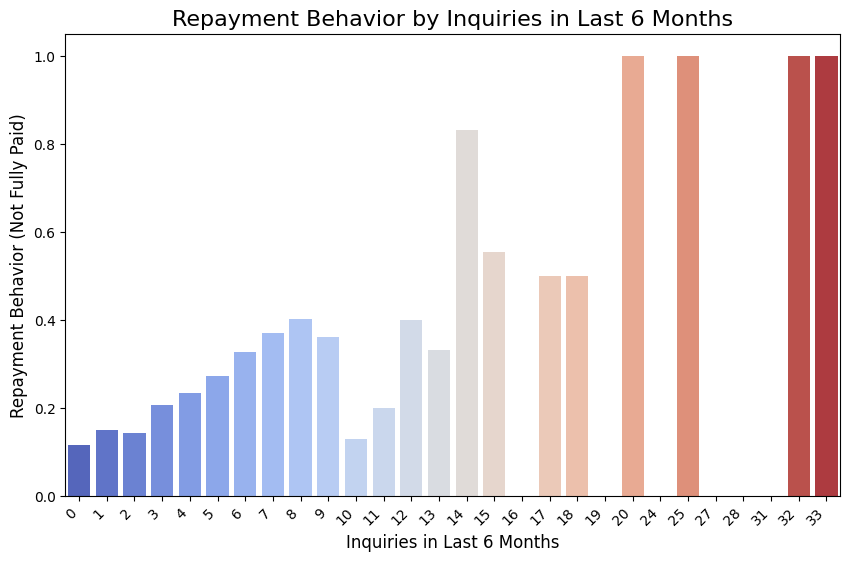

In [12]:
#group by 'inq.last.6mths' & calculate average repayment behavior ('not.fully.paid')
inq_rep_behavior = df.groupby('inq.last.6mths')['not.fully.paid'].mean()

#bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=inq_rep_behavior.index, y=inq_rep_behavior.values, palette='coolwarm')
plt.title('Repayment Behavior by Inquiries in Last 6 Months', fontsize=16)
plt.xlabel('Inquiries in Last 6 Months', fontsize=12)
plt.ylabel('Repayment Behavior (Not Fully Paid)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

<ipython-input-13-2c89dbb62519>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delinq_rep_behavior.index, y=delinq_rep_behavior.values, palette='coolwarm')


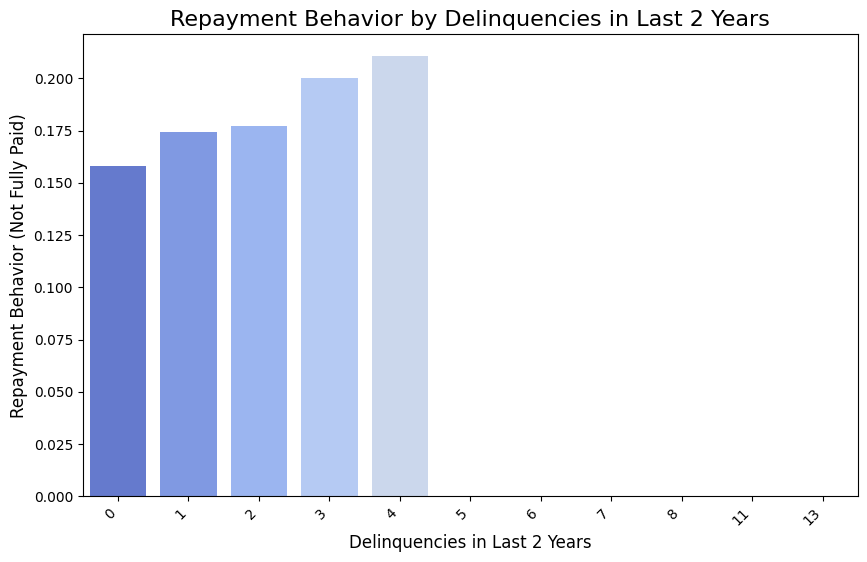

In [13]:
#group by 'delinq.2yrs' & calculate average repayment behavior ('not.fully.paid')
delinq_rep_behavior = df.groupby('delinq.2yrs')['not.fully.paid'].mean()

#bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=delinq_rep_behavior.index, y=delinq_rep_behavior.values, palette='coolwarm')
plt.title('Repayment Behavior by Delinquencies in Last 2 Years', fontsize=16)
plt.xlabel('Delinquencies in Last 2 Years', fontsize=12)
plt.ylabel('Repayment Behavior (Not Fully Paid)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

<ipython-input-14-fc4014ff9f6e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pub_rec_rep_behavior.index, y=pub_rec_rep_behavior.values, palette='coolwarm')


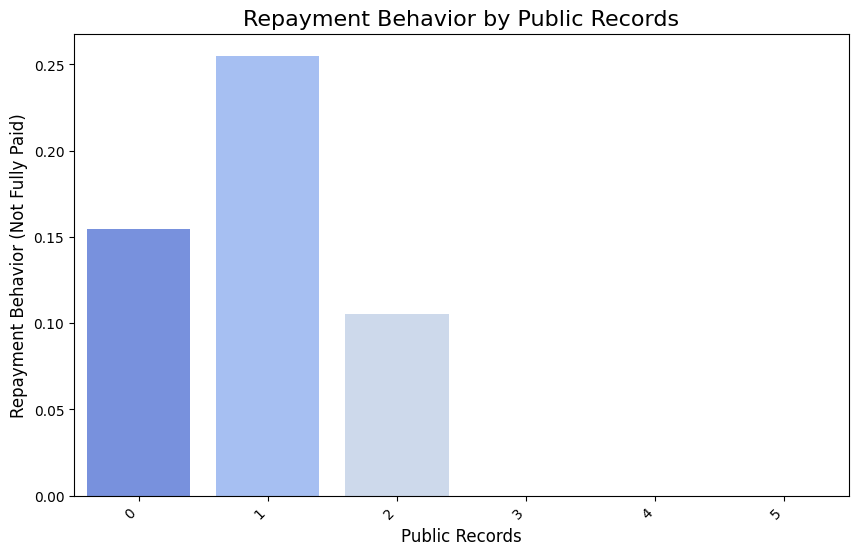

In [14]:
#group by 'pub.rec' & calculate average repayment behavior ('not.fully.paid')
pub_rec_rep_behavior = df.groupby('pub.rec')['not.fully.paid'].mean()

#bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=pub_rec_rep_behavior.index, y=pub_rec_rep_behavior.values, palette='coolwarm')
plt.title('Repayment Behavior by Public Records', fontsize=16)
plt.xlabel('Public Records', fontsize=12)
plt.ylabel('Repayment Behavior (Not Fully Paid)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

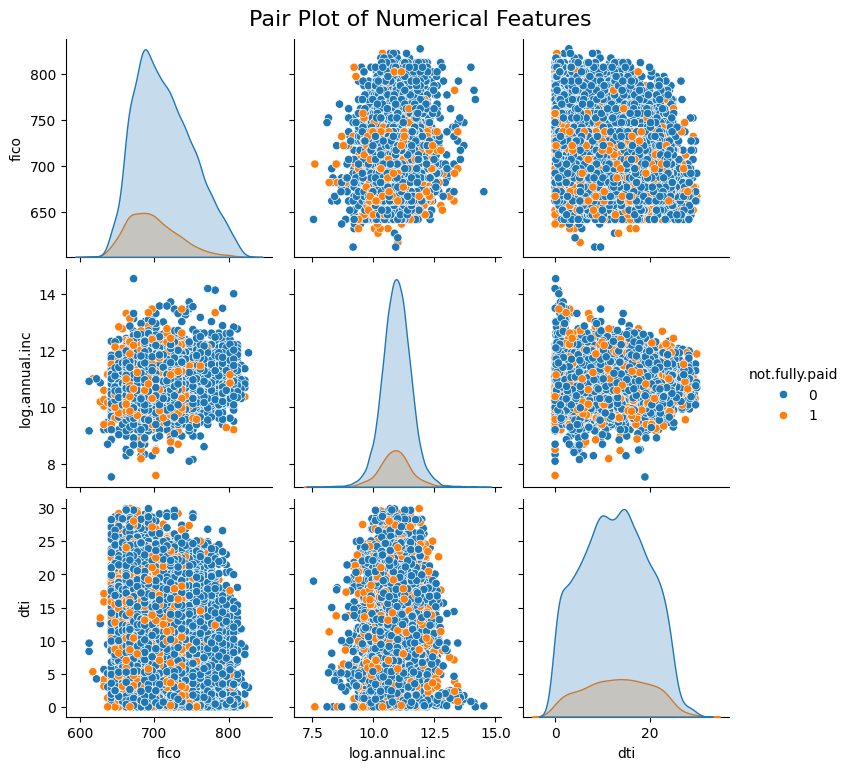

In [15]:
#create pair plot to visualize relationships between 'fico', 'log.annual.inc', 'dti', & 'not.fully.paid'
pair_plot = sns.pairplot(df[['fico', 'log.annual.inc', 'dti', 'not.fully.paid']], hue='not.fully.paid')

#title
plt.suptitle('Pair Plot of Numerical Features', y=1.02, fontsize=16)

#legend
pair_plot._legend.set_bbox_to_anchor((1, 0.5))
plt.show()

In [16]:
#one-hot encoding 'purpose' categorical column
df = pd.get_dummies(df, columns=['purpose'], drop_first=True)

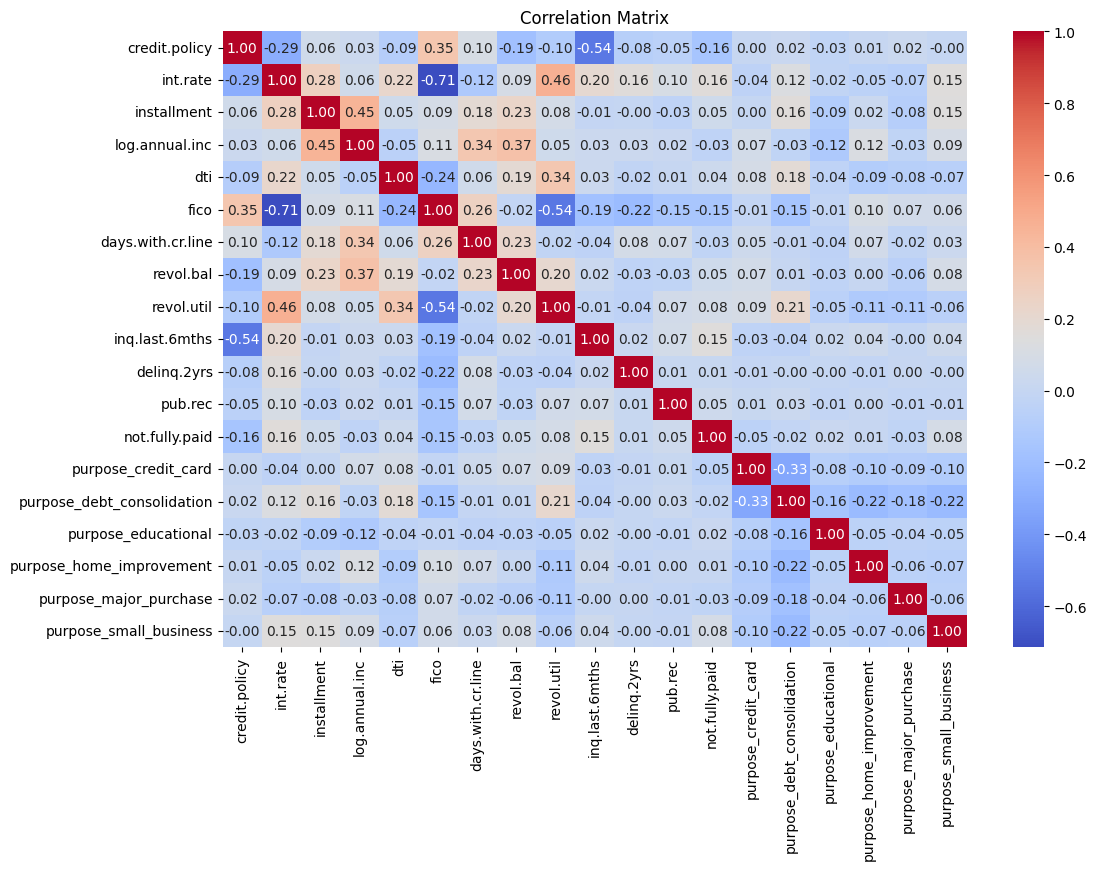

In [17]:
#correlation matrix to see relationship between features
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [18]:
#drop features
feat_drop = ['inq.last.6mths', 'delinq.2yrs', 'pub.rec']
df.drop(feat_drop, axis=1, inplace=True)

###Step 3: Feature Engineering


In [19]:
#using StandardScaler to standardize features
continuous_feat = ['dti', 'installment']
scaler = StandardScaler()
df[continuous_feat] = scaler.fit_transform(df[continuous_feat])

In [20]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,not.fully.paid
count,9578.000000,9578.000000,9.578000e+03,9578.000000,9.578000e+03,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000
mean,0.804970,0.122640,-4.896202e-17,10.932117,-7.121748e-17,710.846314,4560.767197,1.691396e+04,46.799236,0.160054
std,0.396245,0.026847,1.000052e+00,0.614813,1.000052e+00,37.970537,2496.930377,3.375619e+04,29.014417,0.366676
min,0.000000,0.060000,-1.465366e+00,7.547502,-1.831405e+00,612.000000,178.958333,0.000000e+00,0.000000,0.000000
25%,1.000000,0.103900,-7.501161e-01,10.558414,-7.836264e-01,682.000000,2820.000000,3.187000e+03,22.600000,0.000000
50%,1.000000,0.122100,-2.421486e-01,10.928884,8.472466e-03,707.000000,4139.958333,8.596000e+03,46.300000,0.000000
75%,1.000000,0.140700,5.489849e-01,11.291293,7.762382e-01,737.000000,5730.000000,1.824950e+04,70.900000,0.000000
max,1.000000,0.216400,2.999368e+00,14.528354,2.520962e+00,827.000000,17639.958330,1.207359e+06,119.000000,1.000000


In [21]:
#converting 'credit.policy' & 'not.fully.paid' columns to boolean
df['credit.policy'] = df['credit.policy'].astype(bool)
df['not.fully.paid'] = df['not.fully.paid'].astype(bool)

In [22]:
df[['credit.policy', 'not.fully.paid']].dtypes

,0
credit.policy,bool
not.fully.paid,bool
